# 正則化

*Regularization*

目的関数に正則化項を追加し、モデルの複雑さを抑える手法。過学習を抑制する手法の一つ。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
np.random.seed(11)

x_range = (-1, 2.5)
def get_samples(n):
    x = np.random.uniform(*x_range, n)
    y = np.sin(x) + 0.2 * np.random.randn(n)
    return x.reshape(-1, 1), y

def evaluate(model, X_train, X_test, y_train, y_test):
    score_train = r2_score(y_train, model.predict(X_train))
    score_test = r2_score(y_test, model.predict(X_test))
    print(f"score (train): {score_train:.2f}")
    print(f"score (test): {score_test:.2f}")

    x_axis = np.linspace(*x_range, 100).reshape(-1, 1)
    y_pred = model.predict(x_axis)
    plt.scatter(X_train, y_train, label="train")
    plt.scatter(X_test, y_test, label="test")
    plt.plot(x_axis, y_pred, color="red", label="trained model")
    plt.ylim(-2, 2)
    plt.legend()

前章で、モデルが複雑すぎると過学習が起こると学んだ。そこで、モデルの複雑さを表す関数を正則化項として目的関数に追加し、モデルを単純にすることを考える。

$$
J(\theta) = L(\theta) + \alpha R(\theta)
$$

$L(\theta)$は従来の目的関数で、予測精度を表す。ここに正則化項$\alpha R(\theta)$を追加したものを新たな目的関数$J(\theta)$として定義する。

$\alpha$は正則化の強さを表す**ハイパーパラメータ**である。ハイパーパラメータとは、学習によって最適化されることはなく、人間が設定する必要がある。どの値が適切かはその人の経験や試行錯誤によって判断する。

$R(\theta)$はモデルの複雑さを表す関数であるが、どのような関数を設定すると良いだろうか。

ここで、過学習が起きた場面でパラメータがどうなっているかを考える。

score (train): 1.00
score (test): -104.33


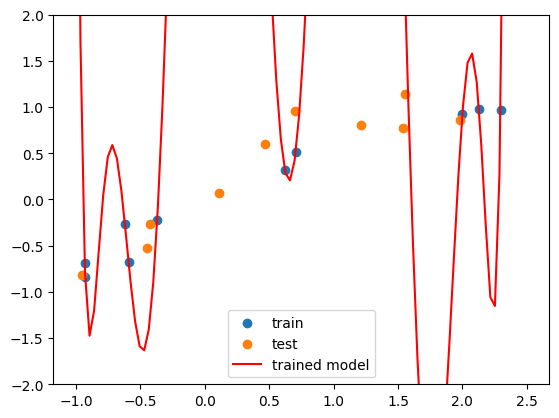

In [2]:
X, y = get_samples(20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=11
)
poly = PolynomialFeatures(degree=10, include_bias=False)
model = LinearRegression()
pipeline = Pipeline([("poly", poly), ("model", model)])
pipeline.fit(X_train, y_train)
evaluate(pipeline, X_train, X_test, y_train, y_test)

これが過学習が起きている状態。このモデルの重みパラメータ（回帰係数）を見てみる。

In [3]:
pipeline["model"].coef_

array([  22.74844245, -115.45019848, -101.477524  ,  326.12046108,
        102.23887979, -379.95152819,   60.39512133,  151.18811997,
        -82.42705856,   12.50966179])

過学習が起きていない場合と比較してみよう。

score (train): 0.91
score (test): 0.84


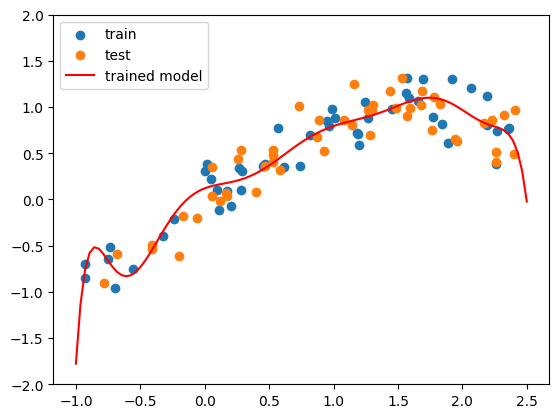

In [4]:
X, y = get_samples(100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=11
)
poly = PolynomialFeatures(degree=10, include_bias=False)
model = LinearRegression()
pipeline = Pipeline([("poly", poly), ("model", model)])
pipeline.fit(X_train, y_train)
evaluate(pipeline, X_train, X_test, y_train, y_test)

In [5]:
pipeline["model"].coef_

array([  0.53555486,  -1.92874242,   4.46035088,   2.04519679,
       -10.04597545,   4.59699978,   4.54866357,  -5.10718561,
         1.78704713,  -0.21817235])

過学習が起きているモデルは重みパラメータの絶対値が大きいことが分かる。ということで、$R(\theta)$はパラメータの絶対値の大きさを表す関数として設定すると良さそうだ。

次節以降で、$R(\theta)$に具体的な関数を設定し、実際に学習を行う。


---

## 



## Ridge回帰

正則化項にパラメータの二乗和を用いた線形回帰モデル。L2正則化とも呼ばれる。Ridgeの読み方はリッジ。

$$
\begin{align}
J(\bm w)
    &= \| \bm y - \bm X \bm w \|_2^2 + \alpha R(\bm w) \\
    &= \| \bm y - \bm X \bm w \|_2^2 + \alpha \| \bm w \|_2^2 \\
    &= \sum_{n=1}^N (y^{(n)} - \bm w^T\bm x^{(n)})^2 + \alpha \sum_{i=1}^mw_i^2
\end{align}
$$

解き方は同じで、微分して0になる点を求めるだけ。

一つ目の項の微分は前章で求めているので、そこに正則化項の微分を足す。

$$
\begin{align}
\frac{\partial J}{\partial \bm w}
	&= -2X^T\bm y + 2X^TX\bm w + \frac{\partial}{\partial \bm w}\alpha\|\bm w\|_2^2 \\
	&= -2X^T\bm y + 2X^TX\bm w + 2\alpha\bm w
\end{align}
$$

これが0になる点を求める。

$$
\begin{align}
-2X^T\bm y + 2X^TX\bm w + 2\alpha\bm w &= 0 \\
X^TX\bm w + \alpha\bm w &= X^T\bm y \\
X^TX\bm w + \alpha I\bm w &= X^T\bm y \\
(X^TX\bm + \alpha I)\bm w &= X^T\bm y \\
\bm w &= (X^TX + \alpha I)^{-1}X^T\bm y
\end{align}
$$

おわり。$\alpha I$が足されただけ。$I$は単位行列。

実装してみる。

In [6]:
class RidgeRegression:
    def __init__(self, alpha=1.):
        self.alpha = alpha
        self.weights = None

    def fit(self, X, y):
        X = np.insert(X, 0, 1, axis=1)
        I = np.identity(X.shape[1], dtype=np.float32)
        I[0, 0] = 0 # バイアス項は無視
        self.weights = np.linalg.inv(X.T @ X + self.alpha*I) @ X.T @ y

    def predict(self, X):
        X = np.insert(X, 0, 1, axis=1)
        return X @ self.weights

バイアスに当たる$w_0$は正則化しない。しても過学習の抑制につながらないため。

$\alpha I$の$w_0$に対応する部分を0にすることで$w_0$については通常の線形回帰と同じ値になるため、正則化をしないことと同じ意味になる。

これを学習させてみる。

score (train): 0.94
score (test): 0.82


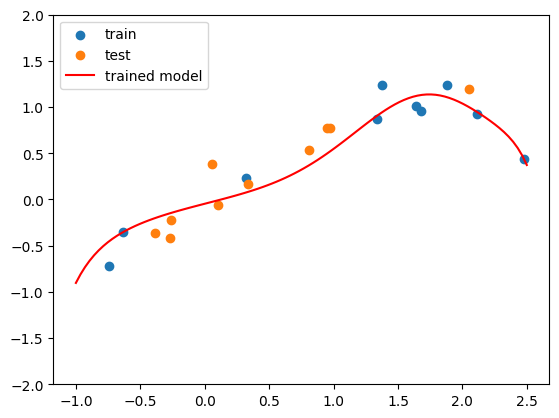

In [7]:
X, y = get_samples(20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=11
)
poly = PolynomialFeatures(degree=10, include_bias=False)
model = RidgeRegression(alpha=1.)
pipeline = Pipeline([("poly", poly), ("model", model)])
pipeline.fit(X_train, y_train)
evaluate(pipeline, X_train, X_test, y_train, y_test)

先ほどは過学習を起こしていた場面（少ないデータ&複雑なモデル）だが、正則化によって過学習が抑制された。

sklearnの結果とも一致している。

In [8]:
model.weights[1:]

array([ 0.36112183, -0.01539918,  0.22140604,  0.00320725,  0.10460641,
       -0.05035217, -0.00845362, -0.06037318,  0.04660311, -0.00863915])

In [9]:
from sklearn.linear_model import Ridge
correct_model = Ridge(alpha=1.)
pipeline = Pipeline([("poly", poly), ("model", correct_model)])
pipeline.fit(X_train, y_train)
pipeline["model"].coef_

array([ 0.36112183, -0.01539918,  0.22140604,  0.00320725,  0.10460641,
       -0.05035217, -0.00845362, -0.06037318,  0.04660311, -0.00863915])


---

## Lasso回帰


In [10]:
# x = np.linspace(-2, 5, 100)
# y = (5 - x) ** 2 + 5 * np.abs(x)
# plt.plot(x, y)

In [11]:
class LassoRegression:
    def __init__(self, alpha: float = 1., max_iter: int = 1000):
        self.alpha = alpha
        self.max_iter = max_iter
        self.weights = None

    @staticmethod
    def soft_threshold(x, thre):
        if x > thre:
            return x - thre
        elif x < -thre:
            return x + thre
        else:
            return 0

    def fit(self, X, y):
        # X = np.insert(X, 0, 1, axis=1)
        n_features = X.shape[1]
        self.weights = np.zeros(n_features)
        for _ in range(self.max_iter):
            for i in range(n_features):
                weights = self.weights.copy()
                weights[i] = 0
                r = y - X @ weights
                c = X[:, i] @ r
                a = np.linalg.norm(X[:, i]) ** 2
                self.weights[i] = self.soft_threshold(c / a, self.alpha)

    def predict(self, X):
        # X = np.insert(X, 0, 1, axis=1)
        return X @ self.weights